In [1]:
import os
from pathlib import Path
from typing import List, Union

from haystack.components.preprocessors import DocumentCleaner
from haystack_integrations.document_stores.chroma import ChromaDocumentStore
from haystack.components.converters import TextFileToDocument, PyPDFToDocument
from haystack.components.converters.docx import DOCXToDocument
from haystack.components.converters.csv import CSVToDocument
from haystack.components.converters import JSONConverter
from haystack.components.converters import XLSXToDocument
from haystack.components.converters import TikaDocumentConverter
from haystack.components.converters import MarkdownToDocument
from haystack.components.routers import FileTypeRouter
from haystack.components.joiners.document_joiner import DocumentJoiner
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.writers import DocumentWriter
from haystack.components.routers import ConditionalRouter
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack import Pipeline
from haystack import component, Document
from haystack.dataclasses import ByteStream
import pickle
import nltk
import numpy as np

import pickle, nltk
from rank_bm25 import BM25L                     # можно BM25Okapi/BM25Plus
from nltk.tokenize import word_tokenize

import fitz                   # PyMuPDF, для быстрой проверки наличия текста :contentReference[oaicite:0]{index=0}
from pdf2image import convert_from_path  # конвертация PDF→PIL.Image :contentReference[oaicite:1]{index=1}
import pytesseract            # обёртка над Tesseract OCR :contentReference[oaicite:2]{index=2}
import logging

logger = logging.getLogger(__name__)


In [2]:
import mimetypes
mimetypes.add_type("application/json", ".json")

In [3]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/skitarii/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# !pip install tika
# !pip install openpyxl
# !pip install tabulate
# !pip install pygraphviz
# !pip install hf_xet
# !pip install markdown-it-py mdit_plain
# !pip install rank_bm25 nltk
# !pip install pdf2image

In [5]:
# Инициализация хранилища (Chroma) с сохранением на диск
embedding_store = ChromaDocumentStore(persist_path="../data/chroma_index")

In [6]:
# def build_bm25(docs: list[Document], path: str = "../data/bm25.pkl"):
#     # гарантируем наличие каталога
#     Path(path).parent.mkdir(parents=True, exist_ok=True)

#     # строим индекс
#     corpus  = [word_tokenize(d.content.lower()) for d in docs]
#     doc_ids = [d.id for d in docs]
#     bm25    = BM25L(corpus)                # можно BM25Okapi / BM25Plus

#     # сохраняем
#     with open(path, "wb") as f:
#         pickle.dump((bm25, doc_ids), f)

In [7]:
# Инициализация компонентов
file_router = FileTypeRouter(
    mime_types=[
        "text/plain",                        # .txt, .yml
        "text/csv",                          # .csv
        "text/markdown",                     # .md
        "application/json",                  # .json
        "application/pdf",                   # .pdf
        "application/msword",                # .doc
        "application/vnd.openxmlformats-officedocument.wordprocessingml.document",  # .docx
        "application/epub+zip",              # .epub
        "application/vnd.ms-excel",          # .xls
        "application/vnd.openxmlformats-officedocument.spreadsheetml.sheet",        # .xlsx
    ]
)
# --- конвертеры ---
# txt_converter = TextFileToDocument(errors="ignore")
txt_utf8 = TextFileToDocument()                 # encoding="utf-8" по умолчанию
txt_cp   = TextFileToDocument(encoding="cp1251")# второй конвертер под Windows‑1251
csv_converter   = CSVToDocument()
# в пайплайне json файлы нужно просто читать как текст 
# без проверки валидности формата или извлечения данных по схеме
# все файлы будут разные, нельзя предусмотреть схему
json_converter  = TextFileToDocument()
# pdf_converter = PyPDFToDocument() 
tika_doc_converter  = TikaDocumentConverter()   # .doc
tika_epub_converter  = TikaDocumentConverter()  # .epub
tika_xls_converter  = TikaDocumentConverter()   # .xls
docx_converter = DOCXToDocument()
xlsx_converter  = XLSXToDocument(table_format="markdown")
tika_unclassified_converter  = TikaDocumentConverter()   # for all other
md_converter = MarkdownToDocument()

In [8]:
# --- объединитель ---
joiner = DocumentJoiner(join_mode="concatenate")

In [9]:
cleaner = DocumentCleaner(
    remove_empty_lines=True,
    remove_extra_whitespaces=True,
    remove_repeated_substrings=True, 
)
splitter = DocumentSplitter(
    split_by="word",
    split_length=500, 
    split_overlap=100
)
embedder = SentenceTransformersDocumentEmbedder("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
embedding_writer = DocumentWriter(document_store=embedding_store)

In [10]:
@component
class OverlapToStr:
    """
    _split_overlap: [{'range': (s, e), …}] → "s:e"
    """
    @component.output_types(documents=list[Document])
    def run(self, documents: List[Document]):
        for d in documents:
            ov = d.meta.get("_split_overlap")
            # ov = [{'range': (start, end), ...}]
            if (isinstance(ov, list) and ov
                    and isinstance(ov[0], dict)
                    and "range" in ov[0]):
                s, e = ov[0]["range"]
                d.meta["_split_overlap"] = f"{s}:{e}"
        return {"documents": documents}


In [11]:
@component
class EncodingSplitter:
    @component.output_types(utf8=List[str], cp=List[str])
    def run(
        self,
        sources: List[Union[str, Path, ByteStream]]   # ← тип совпадает с роутером
    ):
        utf8_files, cp_files = [], []
        for src in sources:
            # превращаем ByteStream → Path или пропускаем
            path = Path(src) if isinstance(src, (str, Path)) else None
            if not path:
                continue
            try:
                path.read_text(encoding="utf-8")
                utf8_files.append(str(path))
            except UnicodeDecodeError:
                cp_files.append(str(path))
        return {"utf8": utf8_files, "cp": cp_files}

In [12]:
@component
class OCRPDFToDocument:
    """
    Конвертирует PDF-файлы:
      – если в PDF есть текстовый слой → быстрое извлечение через PyMuPDF;
      – иначе (сканы, пустые, повреждённые) → распознавание через pytesseract.
    Выходной сокет: 'documents' (List[Document]) :contentReference[oaicite:3]{index=3}.
    """
    @component.output_types(documents=List[Document])
    def run(self, sources: List[Union[str, Path]]) -> dict:
        all_docs: List[Document] = []
        for src in sources:
            path = Path(src)
            try:
                # 1) Открываем PDF и пытаемся извлечь «сырой» текст
                pdf = fitz.open(path)  
                text_pages = [page.get_text("text", sort=True) for page in pdf]  
                full_text = "\n".join(text_pages).strip()  
                # если получилось >20 символов — считаем, что текстовый слой есть
                if len(full_text) >= 20:
                    all_docs.append(Document(
                        content=full_text,
                        meta={"name": path.name, "ocr_used": False}
                    ))
                    continue
            except Exception as e:
                logger.debug(f"PyMuPDF failed on {path.name}: {e}")
            
            # 2) PDF без текста — конвертируем страницы в изображения
            try:
                images = convert_from_path(str(path), dpi=300)
            except Exception as e:
                logger.error(f"PDF→Image conversion failed for {path.name}: {e}")
                continue

            # 3) На каждой странице запускаем Tesseract OCR
            page_texts: List[str] = []
            for i, img in enumerate(images):
                try:
                    txt = pytesseract.image_to_string(img, lang="rus+eng")
                    page_texts.append(txt)
                except Exception as exc:
                    logger.error(f"OCR failed on page {i+1} of {path.name}: {exc}")

            ocr_content = "\n".join(page_texts).strip()
            if ocr_content:
                all_docs.append(Document(
                    content=ocr_content,
                    meta={
                        "name": path.name,
                        "ocr_used": True,
                        "page_count": len(images)
                    }
                ))
            else:
                logger.warning(f"No text extracted from {path.name} even after OCR")
        return {"documents": all_docs}


In [13]:
@component
class PDFFastOrOCRRouter:
    """
    Разбивает источники PDF на две группы:
      – fast: файлы с текстовым слоем (PyPDFToDocument);
      – ocr : сканы и пустые (OCRPDFToDocument).
    """
    @component.output_types(fast=List[str], ocr=List[str])
    def run(self, sources: List[Union[str, Path, ByteStream]]) -> dict:
        fast, ocr = [], []
        for src in sources:
            # Подготовка пути: если ByteStream, сохраняем во временный файл
            if isinstance(src, ByteStream):
                suffix = src.metadata.get("mime_type", "").split("/")[-1] or "pdf"
                tmp = tempfile.NamedTemporaryFile(delete=False, suffix=f".{suffix}")
                tmp.write(src.data)
                tmp.flush()
                tmp.close()
                path = Path(tmp.name)
            else:
                path = Path(src)

            # Пытаемся быстрый текстовый путь (PyMuPDF)
            try:
                pdf = fitz.open(path)
                text = "".join(page.get_text("text", sort=True) for page in pdf).strip()
                if len(text) >= 20:
                    fast.append(str(path))
                    continue
            except Exception:
                # если PyMuPDF упал — переходим к OCR
                pass

            # Во всех остальных случаях — ветка OCR
            ocr.append(str(path))

        # Возвращаем два списка путей
        return {"fast": fast, "ocr": ocr}

In [14]:
@component
class BM25Builder:
    """
    Строит BM25‑индекс из списка документов и сохраняет его в файл.
    
    Вход:
      - documents: List[Document]  — документы с .content и .id
      - path     : str             — путь для сохранения (pickle)
    Выход:
      - documents: List[Document]  — тот же список документов
    """
    @component.output_types(documents=List[Document])
    def run(self, documents: List[Document], path: str = "../data/bm25.pkl") -> dict:
        # 1️⃣ создаём папку, если её нет
        output_path = Path(path)
        output_path.parent.mkdir(parents=True, exist_ok=True)

        # 2️⃣ подготавливаем корпус: токенизируем каждое содержание
        corpus = [
            word_tokenize(doc.content.lower())
            for doc in documents
        ]
        doc_ids = [doc.id for doc in documents]

        # 3️⃣ строим индекс BM25L (можно BM25Okapi или BM25Plus)
        bm25 = BM25L(corpus)

        # 4️⃣ сохраняем в pickle: кортеж (bm25, doc_ids)
        with open(output_path, "wb") as f:
            pickle.dump((bm25, doc_ids), f)

        # 5️⃣ возвращаем документы дальше по пайплайну
        return {"documents": documents}

In [15]:
overlap_fix = OverlapToStr()

# Инициализируем конвертеры
pdf_router = PDFFastOrOCRRouter()
pdf_fast = PyPDFToDocument()
ocr_pdf = OCRPDFToDocument()

bm25_builder = BM25Builder()

In [16]:
# Построение пайплайна
indexing_pipeline = Pipeline()
# indexing_pipeline = AsyncPipeline()

indexing_pipeline.add_component("router", file_router)
# indexing_pipeline.add_component("txt_converter", txt_converter)
indexing_pipeline.add_component("enc_split", EncodingSplitter())
indexing_pipeline.add_component("txt_utf8",  txt_utf8)
indexing_pipeline.add_component("txt_cp",    txt_cp)
indexing_pipeline.add_component("md_converter", md_converter)
indexing_pipeline.add_component("csv_converter",  csv_converter)
indexing_pipeline.add_component("json_converter", json_converter)
# indexing_pipeline.add_component("pdf_converter", pdf_converter)
indexing_pipeline.add_component("pdf_router", pdf_router)
indexing_pipeline.add_component("pdf_fast", pdf_fast)
indexing_pipeline.add_component("ocr_pdf", ocr_pdf)

indexing_pipeline.add_component("docx_converter", docx_converter)
indexing_pipeline.add_component("xlsx_converter", xlsx_converter)
indexing_pipeline.add_component("tika_doc_converter", tika_doc_converter)
indexing_pipeline.add_component("tika_epub_converter", tika_epub_converter)
indexing_pipeline.add_component("tika_xls_converter", tika_xls_converter)
indexing_pipeline.add_component("tika_unclassified_converter", tika_unclassified_converter)

indexing_pipeline.add_component("join", joiner)
indexing_pipeline.add_component("cleaner", cleaner)
indexing_pipeline.add_component("splitter", splitter)
indexing_pipeline.add_component("overlap_fix", overlap_fix)
indexing_pipeline.add_component("embedder", embedder)
indexing_pipeline.add_component("bm25_builder", bm25_builder)
indexing_pipeline.add_component("embedding_writer", embedding_writer)

In [17]:
# ───────── Router → Converters ─────────
# 1. текстовые файлы сначала идут в детектор
indexing_pipeline.connect("router.text/plain", "enc_split.sources")
# 2. две ветки на разные конвертеры
indexing_pipeline.connect("enc_split.utf8", "txt_utf8.sources")
indexing_pipeline.connect("enc_split.cp",   "txt_cp.sources")
# indexing_pipeline.connect("router.text/plain",  "txt_converter.sources")     # .txt, .yml
indexing_pipeline.connect("router.text/csv",    "csv_converter.sources")     # .csv
indexing_pipeline.connect("router.text/markdown", "md_converter.sources")    # .md
indexing_pipeline.connect("router.application/json", "json_converter.sources")  # .json

# PDF идут в обычный конвертер; если добавите OCR‑ветку — измените здесь
# indexing_pipeline.connect("router.application/pdf", "pdf_converter.sources")  # .pdf
indexing_pipeline.connect("router.application/pdf", "pdf_router.sources")
#    → «быстрые» PDF → PyPDFToDocument
indexing_pipeline.connect("pdf_router.fast", "pdf_fast.sources")
#    → «сканы» и пустые → OCRPDFToDocument
indexing_pipeline.connect("pdf_router.ocr", "ocr_pdf.sources")

# Office / EPUB / XLS — универсальный Tika
indexing_pipeline.connect("router.application/msword",
                 "tika_doc_converter.sources")                          # .doc
indexing_pipeline.connect("router.application/epub+zip",
                 "tika_epub_converter.sources")                          # .epub
indexing_pipeline.connect("router.application/vnd.ms-excel",
                 "tika_xls_converter.sources")                          # .xls

# DOCX и XLSX — узкоспециализированные конвертеры
indexing_pipeline.connect("router.application/vnd.openxmlformats-officedocument.wordprocessingml.document",
                 "docx_converter.sources")                          # .docx
indexing_pipeline.connect("router.application/vnd.openxmlformats-officedocument.spreadsheetml.sheet",
                 "xlsx_converter.sources")                          # .xlsx

# Всё, что не распознано (или не перечислено)  →  Tika‑fallback
indexing_pipeline.connect("router.unclassified", "tika_unclassified_converter.sources")

🚅 Components
  - router: FileTypeRouter
  - enc_split: EncodingSplitter
  - txt_utf8: TextFileToDocument
  - txt_cp: TextFileToDocument
  - md_converter: MarkdownToDocument
  - csv_converter: CSVToDocument
  - json_converter: TextFileToDocument
  - pdf_router: PDFFastOrOCRRouter
  - pdf_fast: PyPDFToDocument
  - ocr_pdf: OCRPDFToDocument
  - docx_converter: DOCXToDocument
  - xlsx_converter: XLSXToDocument
  - tika_doc_converter: TikaDocumentConverter
  - tika_epub_converter: TikaDocumentConverter
  - tika_xls_converter: TikaDocumentConverter
  - tika_unclassified_converter: TikaDocumentConverter
  - join: DocumentJoiner
  - cleaner: DocumentCleaner
  - splitter: DocumentSplitter
  - overlap_fix: OverlapToStr
  - embedder: SentenceTransformersDocumentEmbedder
  - bm25_builder: BM25Builder
  - embedding_writer: DocumentWriter
🛤️ Connections
  - router.text/plain -> enc_split.sources (List[Union[str, Path, ByteStream]])
  - router.text/csv -> csv_converter.sources (List[Union[str, Path, 

In [18]:
# Подключаем каждый конвертер → joiner
# indexing_pipeline.connect("txt_converter.documents", "join.documents")    # .txt, .yml
# 3. оба конвертера → DocumentJoiner
indexing_pipeline.connect("txt_utf8.documents", "join.documents")
indexing_pipeline.connect("txt_cp.documents",   "join.documents")
indexing_pipeline.connect("csv_converter.documents", "join.documents")    # .csv
indexing_pipeline.connect("md_converter.documents", "join.documents")     # .csv
indexing_pipeline.connect("json_converter.documents", "join.documents")   # .json
# indexing_pipeline.connect("pdf_converter.documents", "join.documents")    # .pdf (или ocr_pdf)
indexing_pipeline.connect("pdf_fast.documents", "join.documents")
indexing_pipeline.connect("ocr_pdf.documents", "join.documents")
indexing_pipeline.connect("docx_converter.documents", "join.documents")   # .docx
indexing_pipeline.connect("xlsx_converter.documents", "join.documents")   # .xlsx
indexing_pipeline.connect("tika_doc_converter.documents", "join.documents")   # .doc
indexing_pipeline.connect("tika_epub_converter.documents", "join.documents")   # .epub
indexing_pipeline.connect("tika_xls_converter.documents", "join.documents")   # .xls
indexing_pipeline.connect("tika_unclassified_converter.documents", "join.documents")   # неопределенные

🚅 Components
  - router: FileTypeRouter
  - enc_split: EncodingSplitter
  - txt_utf8: TextFileToDocument
  - txt_cp: TextFileToDocument
  - md_converter: MarkdownToDocument
  - csv_converter: CSVToDocument
  - json_converter: TextFileToDocument
  - pdf_router: PDFFastOrOCRRouter
  - pdf_fast: PyPDFToDocument
  - ocr_pdf: OCRPDFToDocument
  - docx_converter: DOCXToDocument
  - xlsx_converter: XLSXToDocument
  - tika_doc_converter: TikaDocumentConverter
  - tika_epub_converter: TikaDocumentConverter
  - tika_xls_converter: TikaDocumentConverter
  - tika_unclassified_converter: TikaDocumentConverter
  - join: DocumentJoiner
  - cleaner: DocumentCleaner
  - splitter: DocumentSplitter
  - overlap_fix: OverlapToStr
  - embedder: SentenceTransformersDocumentEmbedder
  - bm25_builder: BM25Builder
  - embedding_writer: DocumentWriter
🛤️ Connections
  - router.text/plain -> enc_split.sources (List[Union[str, Path, ByteStream]])
  - router.text/csv -> csv_converter.sources (List[Union[str, Path, 

In [19]:
# Остальная цепочка принимает ОДИН поток документов
indexing_pipeline.connect("join.documents", "cleaner.documents")
indexing_pipeline.connect("cleaner.documents", "splitter.documents")
indexing_pipeline.connect("splitter.documents", "overlap_fix.documents")
indexing_pipeline.connect("overlap_fix.documents", "embedder.documents")
indexing_pipeline.connect("embedder.documents", "bm25_builder.documents")
indexing_pipeline.connect("bm25_builder.documents", "embedding_writer.documents")

🚅 Components
  - router: FileTypeRouter
  - enc_split: EncodingSplitter
  - txt_utf8: TextFileToDocument
  - txt_cp: TextFileToDocument
  - md_converter: MarkdownToDocument
  - csv_converter: CSVToDocument
  - json_converter: TextFileToDocument
  - pdf_router: PDFFastOrOCRRouter
  - pdf_fast: PyPDFToDocument
  - ocr_pdf: OCRPDFToDocument
  - docx_converter: DOCXToDocument
  - xlsx_converter: XLSXToDocument
  - tika_doc_converter: TikaDocumentConverter
  - tika_epub_converter: TikaDocumentConverter
  - tika_xls_converter: TikaDocumentConverter
  - tika_unclassified_converter: TikaDocumentConverter
  - join: DocumentJoiner
  - cleaner: DocumentCleaner
  - splitter: DocumentSplitter
  - overlap_fix: OverlapToStr
  - embedder: SentenceTransformersDocumentEmbedder
  - bm25_builder: BM25Builder
  - embedding_writer: DocumentWriter
🛤️ Connections
  - router.text/plain -> enc_split.sources (List[Union[str, Path, ByteStream]])
  - router.text/csv -> csv_converter.sources (List[Union[str, Path, 

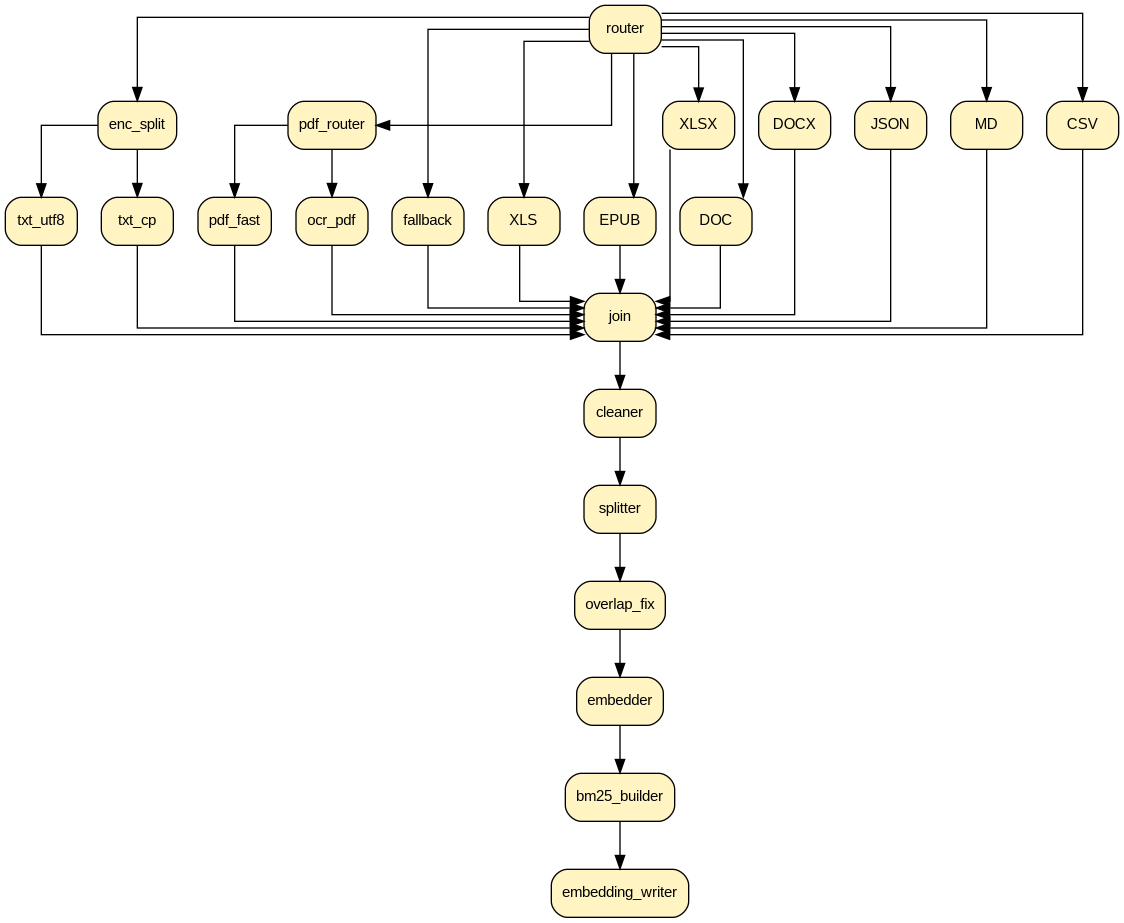

In [20]:
import networkx as nx
from networkx.drawing.nx_agraph import to_agraph
from IPython.display import Image

# 1. копия графа и «читаемые» подписи
H = indexing_pipeline.graph.copy()
nice = {
    "router": "router",
    "txt_converter": "TXT",
    "csv_converter": "CSV",
    "md_converter": "MD",
    "json_converter": "JSON",
    "pdf_converter": "PDF",
    "docx_converter": "DOCX",
    "xlsx_converter": "XLSX",
    "tika_doc_converter": "DOC",
    "tika_epub_converter": "EPUB",
    "tika_xls_converter": "XLS",
    "tika_unclassified_converter": "fallback",
    "join": "join",
    "cleaner": "cleaner",
    "splitter": "splitter",
    "overlap_fix": "overlap_fix",
    "embedder": "embedder",
    "writer": "writer",
}
nx.relabel_nodes(H, nice, copy=False)

# 2. в Graphviz‑объект
A = to_agraph(H)
A.graph_attr.update(rankdir="TB", splines="ortho", bgcolor="white")

# стиль узлов
A.node_attr.update(shape="box", style="filled,rounded", fillcolor="#fff4c2",
                   fontname="Arial", fontsize="11")

# 3. сохраняем/показываем
A.draw("pipeline.png", prog="dot")      # SVG → .svg    PNG → .png
display(Image(filename="pipeline.png")) # Jupyter


In [21]:
file_paths = ["../data/downloaded_files" / Path(name) for name in os.listdir("../data/downloaded_files")]

In [22]:
len(file_paths)

158

In [23]:
from pathlib import PosixPath

In [24]:
# file_paths.remove(PosixPath('../data/downloaded_files/Фролов_К_В_Горные_машины_МЭ,_том_IV_24_2010.pdf'))
# file_paths.remove(PosixPath('../data/downloaded_files/Фролов_К_В_Двигатели_внутреннего_сгорания_МЭ,_том_IV_14_2013.pdf'))
# file_paths.remove(PosixPath('../data/downloaded_files/Фролов_К_В_Авиационные_двигатели_МЭ,_том_IV_21,_книга_3_2010.pdf'))
# file_paths.remove(PosixPath('../data/downloaded_files/Фролов_К_В_Динамика_и_прочность_машин_МЭ,_том_I_3,_книга_1_1994.pdf'))


In [25]:
# file_paths

In [26]:
# indexing_pipeline.run({"router": {"sources": file_paths[20:22]}})

In [27]:
# %%time

# indexing_pipeline.run({"router": {"sources": file_paths}})

In [29]:
%%time


# import nest_asyncio
# nest_asyncio.apply()   # патчит текущий asyncio loop

indexing_pipeline.run({"router": {"sources": file_paths}})

KeyboardInterrupt: 

In [30]:
import pickle

with open("../data/bm25.pkl", "rb") as f:
    bm25, doc_ids = pickle.load(f)
print(f"BM25 объект: {type(bm25)}, документов: {len(doc_ids)}")

BM25 объект: <class 'rank_bm25.BM25L'>, документов: 5829


In [ ]:
import pickle

with open("../data/bm25.pkl", "rb") as f:
    bm25, doc_ids = pickle.load(f)
print(f"BM25 объект: {type(bm25)}, документов: {len(doc_ids)}")

In [ ]:
import pickle

with open("../data/bm25.pkl", "rb") as f:
    bm25, doc_ids = pickle.load(f)
print(f"BM25 объект: {type(bm25)}, документов: {len(doc_ids)}")